# Чтение данных

In [66]:
import pandas as pd
df = pd.read_csv('train.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24712 entries, 0 to 24711
Data columns (total 22 columns):
_id               24712 non-null object
age               24712 non-null int64
job               24712 non-null object
marital           24712 non-null object
education         24712 non-null object
default           24712 non-null object
housing           24712 non-null object
loan              24712 non-null object
contact           24712 non-null object
month             24712 non-null object
day_of_week       24712 non-null object
duration          24712 non-null int64
campaign          24712 non-null int64
pdays             24712 non-null int64
previous          24712 non-null int64
poutcome          24712 non-null object
emp.var.rate      24712 non-null float64
cons.price.idx    24712 non-null float64
cons.conf.idx     24712 non-null float64
euribor3m         24712 non-null float64
nr.employed       24712 non-null float64
target            24712 non-null int64
dtypes: floa

# Функции препроцессинга (объявляем несколько вариантов, вызываем через одну общую функцию)

In [73]:
#функция для разбиения возрастов по группам согласно гипотезе, приведенной в файле.
#group_size - параметр размера каждой группы
#результаты нужно обязательно подвергуть one-hot encoding, так как зависимость нелинейная
def get_age_group(age):
    group_size = 7
    if age <= 17:
        return 1
    if age > 66:
        age = 66
    return 1 + ((age - 17) // group_size)
print(get_age_group(18), get_age_group(27), get_age_group(45), get_age_group(60), get_age_group(80))

1 2 5 7 8


In [74]:
#Cut all unsignificant, define groups where applicable
def preprocessing_1(df):
    
    df["age_group"] = df["age"].map(get_age_group)
    df['pdays'] = df['pdays'].map(lambda x: 0 if x == 999 else 1)
    
    df = df.drop(["_id", "age", "marital", "education", "default", 
                  "housing", "loan", "day_of_week", "cons.price.idx", 
                  "cons.conf.idx", "euribor3m"], axis = 1)
    
    
    df = pd.get_dummies(df, columns=['age_group', 'job', 'contact', 'month', 'poutcome'])
    return df

#Объявим функцию для обработки, внутри которой будем вызывать один из вариантов обработки, которые опишем выше
def preprocessing(df_input, algorithm = preprocessing_1):
    return algorithm(df_input)

preprocessing(df).head(5)

,duration,campaign,pdays,previous,emp.var.rate,nr.employed,target,age_group_1,age_group_2,age_group_3,...,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_nonexistent,poutcome_success
0,87,1,1,0,1.4,5228.1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,291,1,1,0,1.1,5191.0,0,0,0,1,...,0,0,0,1,0,0,0,0,1,0
2,182,1,1,0,1.4,5228.1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,180,2,1,0,1.1,5191.0,0,0,0,1,...,0,0,0,1,0,0,0,0,1,0
4,6,1,1,0,-1.7,4991.6,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0


In [75]:
from sklearn.preprocessing import StandardScaler
#обрабатываем данные инициализируем X и Y
df_prepared = preprocessing(df)
Y = df_prepared['target']
X = StandardScaler().fit_transform(df_prepared.drop('target', axis=1))

In [82]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=0.8, random_state=12134)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(19769, 41) (4943, 41) (19769,) (4943,)


C:\Users\Evgeny\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


# Тренировка модели

# Логистическая регрессия

In [83]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(x_train, y_train)
roc_auc_score(y_test, logreg.predict_proba(x_test)[:,1])

0.9301233993721343

# Дерево принятия решений

In [84]:
from sklearn.tree import DecisionTreeClassifier
decision_tree = DecisionTreeClassifier(max_depth = 5)
decision_tree.fit(x_train, y_train)
roc_auc_score(y_test, decision_tree.predict_proba(x_test)[:,1])

0.9072922827788535

# Случайный лес

In [85]:
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier(max_depth = 8)
random_forest.fit(x_train, y_train)
roc_auc_score(y_test, random_forest.predict_proba(x_test)[:,1])

0.9282561055137935

(-0.01, 1.01)

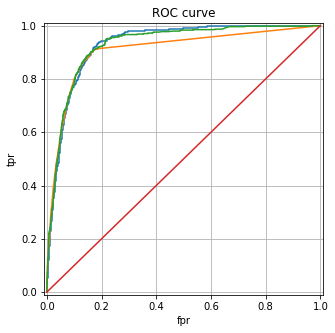

In [86]:
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(x_test)[:,1])
fpr2, tpr2, thresholds2 = roc_curve(y_test, decision_tree.predict_proba(x_test)[:,1])
fpr3, tpr3, thresholds3 = roc_curve(y_test, random_forest.predict_proba(x_test)[:,1])
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr)
plt.plot(fpr2, tpr2)
plt.plot(fpr3, tpr3)
plt.plot([0, 1], [0, 1])
plt.ylabel('tpr')
plt.xlabel('fpr')
plt.grid(True)
plt.title('ROC curve')
plt.xlim((-0.01, 1.01))
plt.ylim((-0.01, 1.01))

In [ ]:
#dum_vars=['job','marital','education','default','housing','loan','contact','month',
#          'day_of_week','poutcome','previous','_id','target']

In [ ]:
#for_preprocess = df.columns.values.tolist()

In [ ]:
#for_preprocess_v = [v for v in for_preprocess if v not in dum_vars  and v != 'y']

In [ ]:
#df_ = df[for_preprocess_v]

In [ ]:
#dum_vars=['housing','loan']

In [ ]:
#создаем dummy variables для колонок с категориальными переменными.
#for var in dum_vars:
   # dummies = pd.get_dummies(df[var], prefix = var)
    #df = df.drop(var,axis = 1)
  #  df_ = df_.join(dummies)

# TO-DO Подготовить категориальные переменные.

In [ ]:
#думаю лучше описать все изменения в одной функции
#я реализовал выше preprocessing_1 и общую функцию preprocessing, которая её вызывает
#если захочется применить альтернативный подход, то достаточно просто дописать альтернативные реализации preprocessing_2, 3 и т.д.

На выходе train и test с категориальными переменными.

# Подготовка train, test

In [ ]:
from sklearn import preprocessing
normalized_X = preprocessing.normalize(X)
standardized_X = preprocessing.scale(X)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=0.8, random_state=1234)

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

# Оценка точности модели

In [ ]:
#валидация
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
kfold = model_selection.KFold(n_splits=10, random_state=42)
modelCV = LogisticRegression()
scoring = 'accuracy'
results = model_selection.cross_val_score(modelCV, X_train, y_train, cv=kfold, scoring=scoring)
print("Средняя точность на 10 фолдах: %.3f" % (results.mean()))

Ниже видно, что recall низкий. Это из за дисбаланса классов

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

Площадь под кривой 0.87. Модель возвращает 87% true positive результатов из всех возможных.

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

# Балансировка выборки. Потому что можем.

In [ ]:
df['target'].value_counts()

Выборка не сбалансирована. В виду ограничения времени используем один метод и сбалансируем выборку вверх. 

In [ ]:
from sklearn.utils import resample
df_majority = df[df.target == 0]
df_minority = df[df.target == 1]

In [ ]:
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=21925,    # to match majority class
                                 random_state=42) 

In [ ]:
# объедими выборки
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

In [ ]:
df_upsampled['target'].value_counts()

In [ ]:
df_ = df_upsampled

In [ ]:
df_ = df_upsampled[for_preprocess_v]

In [ ]:
dum_vars=['housing','loan']

In [ ]:
#создаем dummy variables для колонок с категориальными переменными.
for var in dum_vars:
    dummies = pd.get_dummies(df[var], prefix = var)
    #df = df.drop(var,axis = 1)
    df_ = df_.join(dummies)

In [ ]:
y = df_upsampled['target']
X = df_

In [ ]:
X_train_up, X_test_up, y_train_up, y_test_up = train_test_split(X, y, train_size=0.8, random_state=1234)

In [ ]:
from sklearn.preprocessing import StandardScaler
X_train_up = sc.transform(X_train_up)
X_test_up = sc.transform(X_test_up)

In [ ]:
logreg = LogisticRegression()
logreg.fit(X_train_up, y_train_up)

In [ ]:
#Прогноз на тестовом сете
y_pred = logreg.predict(X_test_up)
print('Точность классификатора на тесте: {:.2f}'.format(logreg.score(X_test_up, y_test_up)))

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test_up, y_pred))

In [ ]:
#Прогноз на тестовом сете
y_pred = logreg.predict(X_test)
print('Точность классификатора на тесте: {:.2f}'.format(logreg.score(X_test, y_test)))

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

# Тренировка модели. Решающие деревья.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
param_grid = {
    'criterion': ['gini'],
    'n_estimators': [1500,2000,2500],
    'max_features': ['auto', 'sqrt'],
}

In [ ]:
cv =  StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)

In [ ]:
model = RandomForestClassifier(random_state = 42)

In [ ]:
random_search = RandomizedSearchCV(model,param_distributions = param_grid, n_jobs = -1, cv = cv, scoring = 'roc_auc',
                                  random_state = 42, n_iter = 5)

In [ ]:
random_search.fit(X_train_up, y_train_up)

In [ ]:
random_search.best_params_

In [ ]:
random_search.best_score_

In [ ]:
# Predicting the Test set results
y_pred = random_search.predict(X_test_up)

In [ ]:
print(classification_report(y_test_up, y_pred))

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test_up, y_pred)
print(confusion_matrix)

In [ ]:
# Predicting the Test set results
y_pred = classifier.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
feature_importances = pd.DataFrame(classifier.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)

In [ ]:
feature_importances

# Используем параметры из GridSearch

In [ ]:
model2 = RandomForestClassifier(criterion=  'gini', max_features = 'sqrt', n_estimators =2500)

In [ ]:
model2.fit(X_train_up, y_train_up)

In [ ]:
df_test = pd.read_csv('test.csv')
X_ = df_test[for_preprocess_v]
X_ = sc.transform(X_)
y_pred = model2.predict(X_)
df_test['target']= y_pred
df_test = df_test[['_id','target']]
df_test.to_csv('submit.csv',index=False)

# Тренировка модели. KNN

# Пока здесь пустынно TO-DO

# Прогноз на тестовой выборке

In [89]:
#выбираем модель
best_model = logreg

In [92]:
df_test = pd.read_csv('test.csv')
df_test.head(5)

,_id,age,job,marital,education,default,housing,loan,contact,month,...,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,66810d8e6bf2b41c880a7bc6c8a1e295,57,technician,married,high.school,no,no,yes,cellular,may,...,371,1,999,1,failure,-1.8,92.893,-46.2,1.299,5099.1
1,ccac3879652b08cb8b44c1920fd93afa,55,unknown,married,unknown,unknown,yes,no,telephone,may,...,285,2,999,0,nonexistent,1.1,93.994,-36.4,4.860,5191.0
2,fcccab4d7a76f70647f015f2c84c2af8,33,blue-collar,married,basic.9y,no,no,no,cellular,may,...,52,1,999,1,failure,-1.8,92.893,-46.2,1.313,5099.1
3,ed8399278c30678dab739045fa12b440,36,admin.,married,high.school,no,no,no,telephone,jun,...,355,4,999,0,nonexistent,1.4,94.465,-41.8,4.967,5228.1
4,1d4d62ac5cabcb48bac7112813f290cb,27,housemaid,married,high.school,no,yes,no,cellular,jul,...,189,2,999,0,nonexistent,1.4,93.918,-42.7,4.963,5228.1


In [93]:
#делаем препроцессинг через функцию (функции пока нет)
ids = df_test['_id']
test_data_prepared = StandardScaler().fit_transform(preprocessing(df_test))


In [94]:
df_test['target']= best_model.predict(test_data_prepared)

In [95]:
df_test[['_id','target']].to_csv('submit.csv',index=False)